In [1]:
import dotenv

dotenv.load_dotenv("/Users/wif/projects/fin_assistant/.env")

True

In [6]:
from typing import Annotated, Optional

from typing_extensions import TypedDict

from finasistant_app.llm import get_default_anthropic_model
from langgraph.graph import StateGraph, START, END
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    MessagesPlaceholder,
)
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from finasistant_app.tools.alphavantage_tools_csv import (
    tools as alphavantage_tools,
)
from finasistant_app.tools.code_writing_tools import tools as code_writing_tools


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = get_default_anthropic_model()
llm_with_alphavantage_tools = llm.bind_tools(alphavantage_tools)


def financial_alphavantage_assistant(state: State):
    template = (
        "You are a helpful assistant. That consults users on data analysis and helps to retrieve necessary data from alphavantage API."
        "If a CSV file info is returned - you need to briefly inform user that data was fetched and ready for further analysis by given file"
        "and provide dataset_description as is returned from the tool in ``` quotes. Do not ask user any follow-up questions."
    )
    system_prompt_message = SystemMessagePromptTemplate.from_template(template)
    prompt = ChatPromptTemplate.from_messages(
        [
            system_prompt_message,
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    llm = prompt | llm_with_alphavantage_tools
    response = llm.invoke({"messages": state["messages"]})
    return {"messages": response}


def write_streamlit_page(state: State):
    system_prompt_message = SystemMessagePromptTemplate.from_template(
        (
            "You are an expert Streamlit developer. Your task is to create a Streamlit page that visualizes data to fulfil user query using plotly library."
            "\nUse a tool you were provided to save code."
            "\nYou MUST pass your code to save_streamlit_page_code tool, into python_code parameter."
            "\nTry to make page as interactive as possible."
            "\nUse data context provided below to write a Streamlit page:"
            "\n<data_context>"
            "\n{data_context}"
            "\n</data_context>"
        )
    )
    prompt = ChatPromptTemplate.from_messages(
        [system_prompt_message, MessagesPlaceholder(variable_name="messages")]
    )
    llm = prompt | llm_with_alphavantage_tools
    response = llm.invoke(
        {"messages": state["messages"], "data_context": state["data_context"]}
    )
    return {"messages": response}


graph_builder.add_node("consult_user", financial_alphavantage_assistant)
graph_builder.add_node("write_streamlit_page", write_streamlit_page)
graph_builder.add_node(
    "fetch_data_with_alphavantage_tools", ToolNode(alphavantage_tools)
)
graph_builder.add_node("write_streamlit_page_tools", ToolNode(code_writing_tools))


graph_builder.add_edge(START, "consult_user")
graph_builder.add_conditional_edges(
    "consult_user",
    tools_condition,
    {"__end__": "__end__", "tools": "fetch_data_with_alphavantage_tools"},
)
graph_builder.add_edge("fetch_data_with_alphavantage_tools", "write_streamlit_page")
graph_builder.add_edge("write_streamlit_page", "write_streamlit_page_tools")
graph_builder.add_edge("write_streamlit_page_tools", END)

graph = graph_builder.compile()


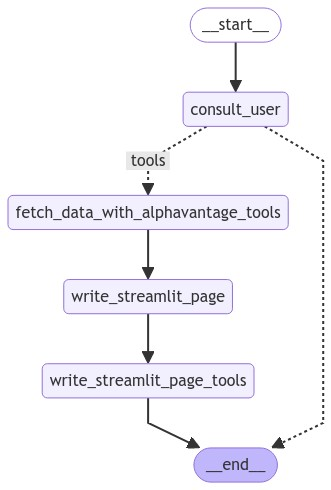

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}, debug=True):
        for value in event.values():
            print("Assistant:", value)

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'messages': ('user', 'show me 5 years of meta data, build interactive chart')}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> ('user', 'show me 5 years of meta data, build interactive chart')
[1:tasks] Starting step 1 with 1 task:
- consult_user -> {'data_context': None,
 'messages': [HumanMessage(content='show me 5 years of meta data, build interactive chart', id='dff9ce39-12f4-4962-9d85-faf3650630ae')]}
Assistant: {'messages': AIMessage(content=[{'text': 'To provide you with 5 years of Meta (formerly Facebook) data and build an interactive chart, we\'ll need to retrieve the data first. Let\'s use the time_series_daily_csv function to get this information. Meta\'s stock symbol is "META". \n\nHere\'s how we\'ll fetch the data:', 'type': 'text'}, {'id': 'toolu_01WLi6yS9K2ZzhASBt1TsQ3Q', 'input': {'symbol': 'META', 'outputsize': 'full'}, 'name': 'time_series_daily_csv', 'type': 'tool_use'}], response_metadata={'id

BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0: all messages must have non-empty content except for the optional final assistant message'}}